# Lane Detection Pipeline for a Still Image

This notebook will help you create a pipeline for Lane Detection using OpenCV on a single frame. The use case in mind is a dashcam pointed at the road ahead of where a car is driving. In this notebook you will learn about Hough transforms and how to apply them to the use case of detecting lanes in a still image. At a high level, the pipeline takes these steps:

+ Create a threshold for lane lines
+ Selecting Region of Interest
+ Detecting Edges using Canny Edge Detector
+ Fit lines using Hough Line Transform
+ Extrapolate the lanes from lines found
+ Composite the result original frame

---

We will start off with identifying the lane lines in a single frame using Hough Transforms which are useful for finding straight line segments within an image.

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

## Create Threshold for Lane Lines

The first step in our workflow is to construct a general threshold that will isolate the lane lines from the asphalt. While the threshold will run over the entire image, we will later isolate our region of interest, so we do not need to worry about the sky and trees and other elements of the scene just yet.

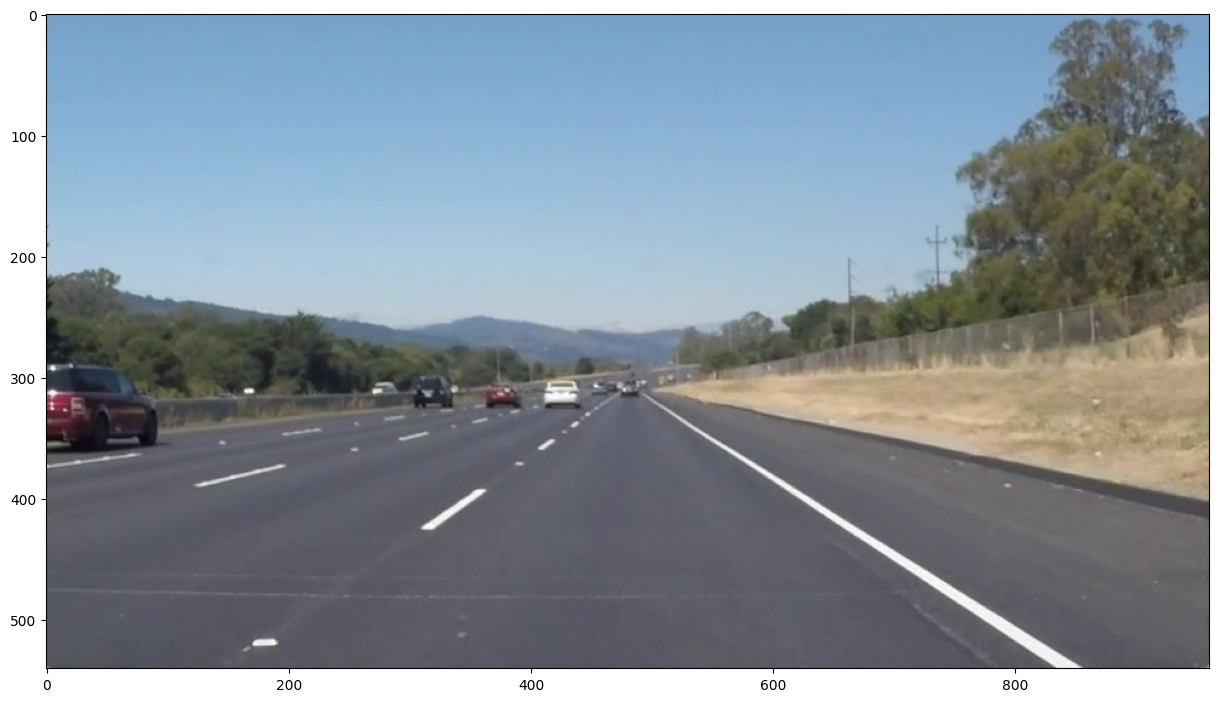

In [4]:
# Reading the image
img = cv2.imread("../module09/test_img1.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(15,10))
plt.imshow(img)

The goal is to extract the left and right lanes around where the car is currently located and extrapolate and draw the lines back onto the image.

---

First, we create a threshold off our image.

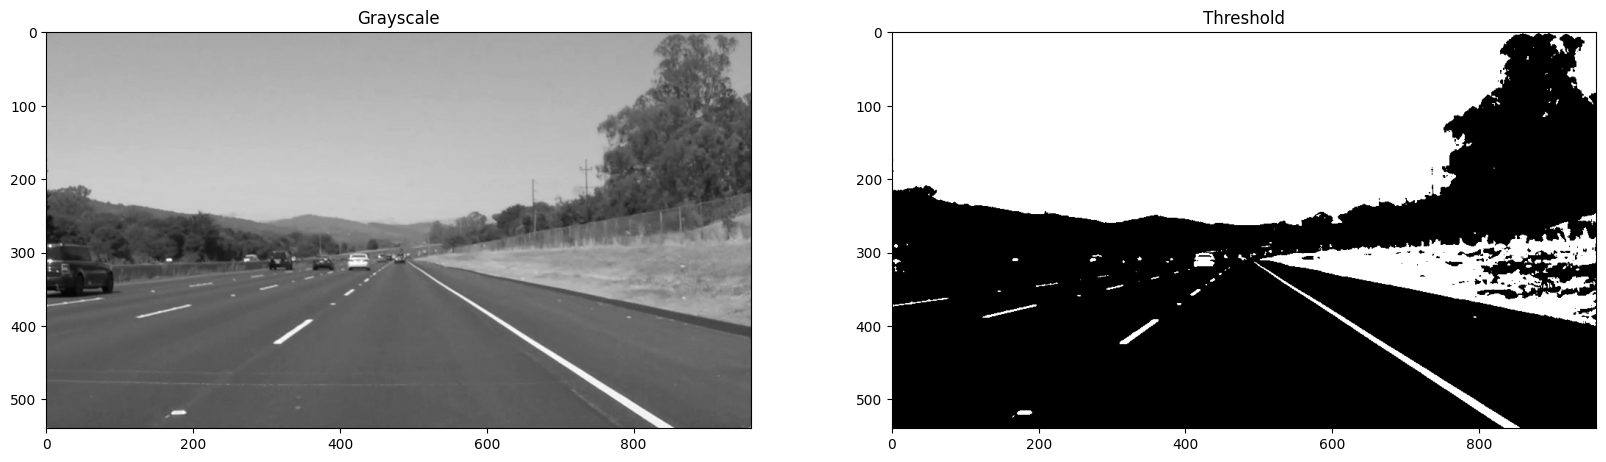

In [5]:
#  Convert to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Use global threshold based on grayscale intensity.
threshold = cv2.inRange(gray, 150, 255)

# Display images.
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1); plt.imshow(gray, cmap="gray"); plt.title("Grayscale");
plt.subplot(1, 2, 2); plt.imshow(threshold, cmap="gray"); plt.title("Threshold");

## 2. Selecting the Region of Interest Using fillPoly()

There is a fair bit of other elements in the scene that later we are going to want to crop out.

The way we are going to crop out and really hone in a particular area of interest is using the __fillPoly__ function. This is a useful function for basically drawing shapes, essentially we pass in a list of vertices and then OpenCV will draw or fill the area we've specified with a given color.

In this case what we are going to intend to do is define a trapezoid-like shape that will basically emulate the larger shape that we expect for a lane, noting given it's a dash cam image we expect that the lane is going to be wide when it's closer to us and much narrower farther away, this will allow us to basically minimize false positives since we can make that sort of assumption given the problem we're trying to solve.

---

The `fillPoly()` function fills the area bounded by one or more polygons.

dst = cv2.fillPoly(img, pts, color[, lineType[, shift[, offset]]])

`dst`: Is the output image of the same size and depth as `img`

The function has __2 required input arguments__ and 4 optional arguments:

1. `image`: Input image
2. `pts`: Array of polygons where each polygon is represented as an array of points
3. `color`: Polygon color
4. `lineTpye`: Type of the polygon boundaries
5. `shift`: Number of fractional bits in the vertex coordinates
6. `offset`: Optinal offset of all points of the contour

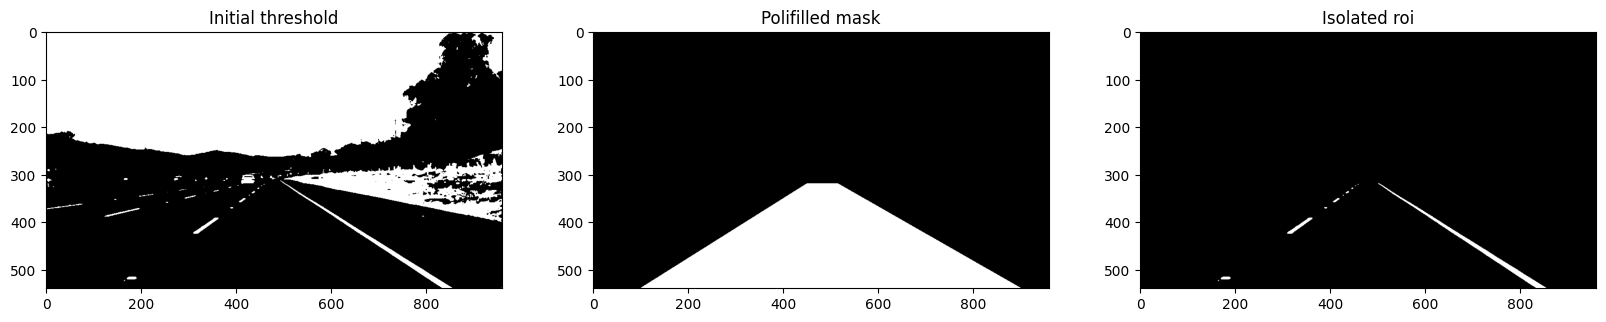

In [6]:
# Region making: Select vertices acording to the input image. | Cols - Rows
roi_vertices = np.array(
    [
        [
            [100, 540],
            [900, 540],
            [515, 320],
            [450, 320]
        ]
    ]
)

# Defining a blank mask
mask = np.zeros_like(threshold)

# Defining a 3 channel or 1 channel color to fill the mask.
if len(threshold.shape) > 2:
    channel_count = threshold.shape[2]  # 3 or 4 depending on the image
    ignore_mask_color = (255,) * channel_count
else:
    ignore_mask_color = 255
    
# Filling pixels inside the polygon.
cv2.fillPoly(mask, roi_vertices, ignore_mask_color)

# Construncting the region of interest based on where mask pixels are nonzero.
roi = cv2.bitwise_and(threshold, mask)

# Display images.
plt.figure(figsize=(20, 10))
plt.subplot(1, 3, 1); plt.imshow(threshold, cmap="gray"); plt.title("Initial threshold");
plt.subplot(1, 3, 2); plt.imshow(mask, cmap="gray"); plt.title("Polifilled mask");
plt.subplot(1, 3, 3); plt.imshow(roi, cmap="gray"); plt.title("Isolated roi");

## 3. Detect Edges and Smooth Noise

Next we need to identify the edges in the image. We can use the Canny edge detection to identify the lane lines, followed by Gaussian blur to smooth out any noise remaining after the edge detection.

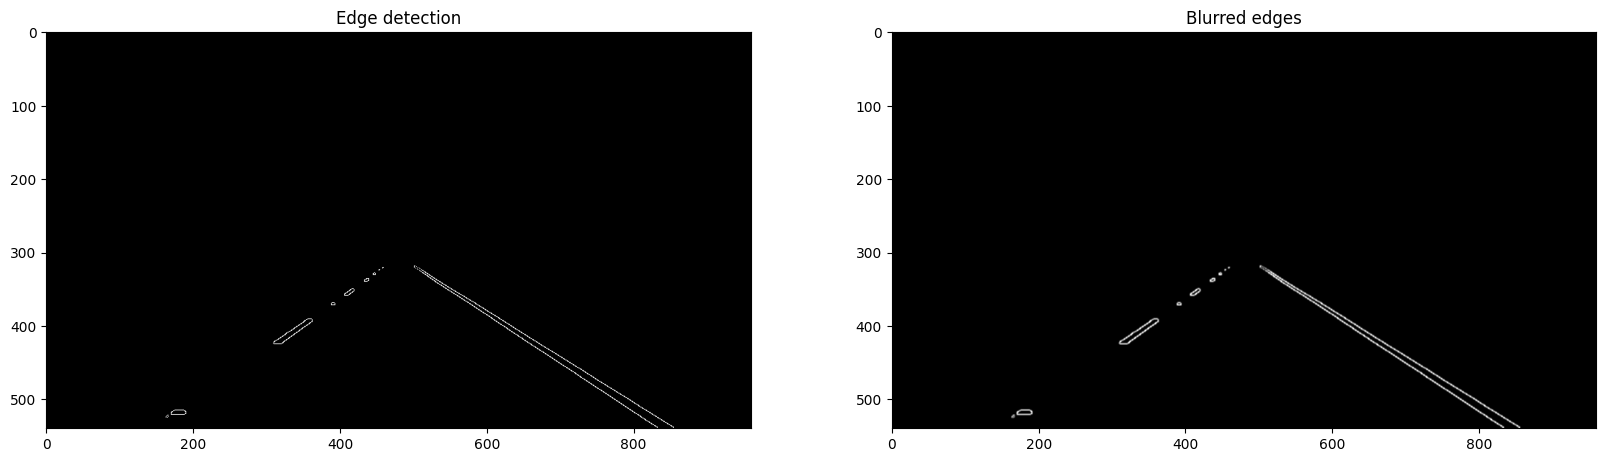

In [7]:
# Perform edge detection.
low_threshold = 50
high_threshold = 100
edges = cv2.Canny(roi, low_threshold, high_threshold)

# Smooth with a Gaussian blur.
kernel_size = 3
canny_blur = cv2.GaussianBlur(edges, (kernel_size, kernel_size), 0)

# Display iamges.
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1); plt.imshow(edges, cmap="gray"); plt.title("Edge detection");
plt.subplot(1, 2, 2); plt.imshow(canny_blur, cmap="gray"); plt.title("Blurred edges");

## 4. Line Detection Using HoughLinesP()

The next step is detect lines in the scene.

`HoughLinesP()` finds line segments in a binary image using the probabilistic Hough Transform. The function implements the probabilistic Hough transform algorithm for line detection.

---

Houg Transform is a way  of translating the coordinate system into another space that's very useful for detecting straight lines within an image.

---

### Function Syntax

lines = cv2.HoughLinesP(image, rho, theta, threshold)

`lines`: Output vector of lines. Each line is represented by a 4-element vector (x1, y1, x2, y2), where (x1, y1) and (x2, y2) are the ending points of each detected line segment.

The function has __4 required input arguments__:

1. `image`: 8-bit, single-channel binary source image.
2. `rho`: Distance resolution of the accumulator in pixels.
3. `theta`: Angle resolution of the accumulator in radians.
4. `threshold`: Returns only those lines which are grater than threshold.

In [8]:
def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """Utility for drawing lines."""
    if lines is not None:
        for line in lines:
            for x1, y1, x2, y2 in line:
                cv2.line(img, (x1, y1), (x2, y2), color, thickness)

Found 24 lines, inclding [[505 319 855 537]]


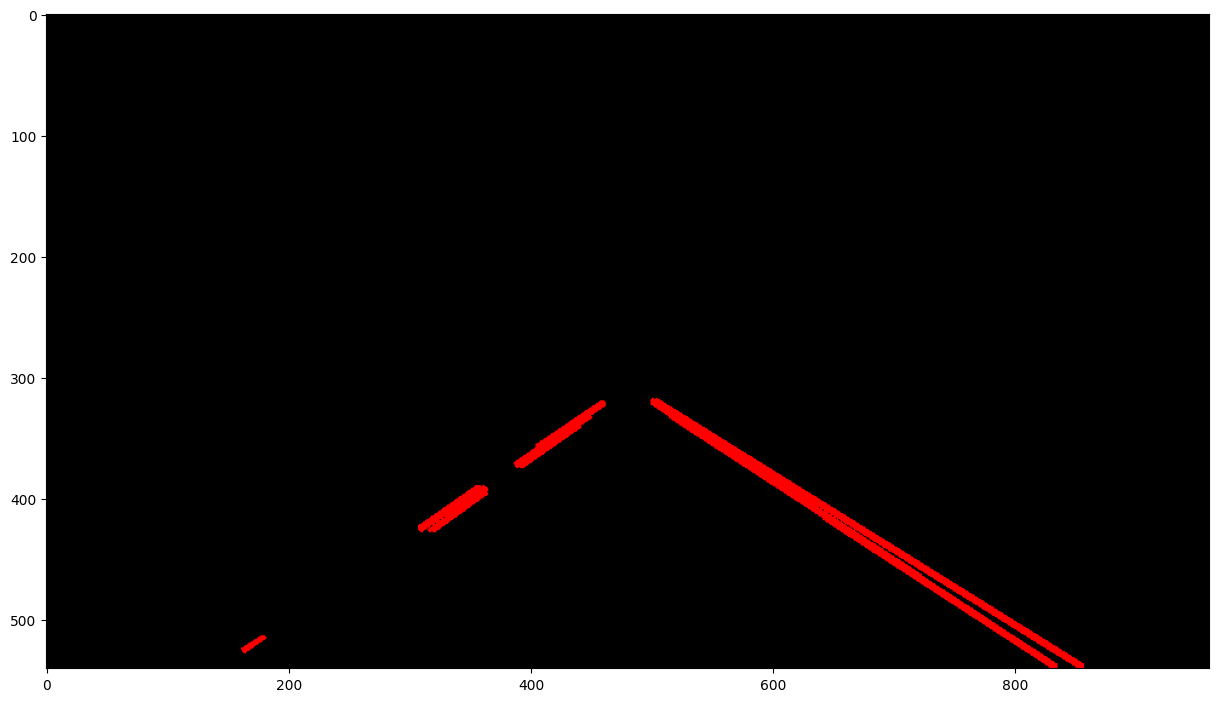

In [9]:
#  Hough transform parameters set according to the input image.
rho = 1
theta = np.pi / 180
threshold = 50
min_line_len = 10
max_line_gap = 20

# We get a list of lines that is detected in the scene.
lines = cv2.HoughLinesP(
    canny_blur,
    rho,
    theta,
    threshold,
    minLineLength=min_line_len,
    maxLineGap=max_line_gap
)

# Draw all lines found onto a new image.
hough = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
draw_lines(hough, lines)

print(f"Found {len(lines)} lines, inclding {lines[0]}")
plt.figure(figsize=(15, 10)); plt.imshow(hough);

In [10]:
lines.shape

(24, 1, 4)

## 5. Separate Sides and Extrapolate

The next step is to separate the left hand side to the right hand side and extrapolate the lines.

In order to do this, we're going to define a number of functions to really separate out the individual stages.

---

The first function separates the left and right lines, we're using the logic of the slopes of the lines to indicate whether it is the left hand side or the right hand side of the lane.

If we want find out which lane is going off to the right for instance, it would actually be indicated by a positive slope in any line detected.

In [11]:
# Function for separating left and right lines depending on the slope.
def separate_left_right_lines(lines):
    """Separate left and right lines depending on the slope."""
    left_lines = []
    right_lines = []
    if lines is not None:
        for line in lines:
            for x1, y1, x2, y2 in line:
                if y1 > y2:  # Negative slope = left lane
                    left_lines.append([x1, y1, x2, y2])
                elif y1 < y2:  # Positive slope = right lane
                    right_lines.append([x1, y1, x2, y2])
    return left_lines, right_lines

In [12]:
# Function to calculate average which will be used in extrapolating lines.
def cal_avg(values):
    """Calculate average value."""
    if not (type(values) == "NoneType"):
        if len(values) > 0:
            n = len(values)
        else:
            n = 1
        return sum(values) / n

#### Function to extrapolate lines

Here, we pass in the list of lines that came from our hough transforms as well as a boundary of an upper and lower border, these borders represent the part of the vertical axes or the y value that we want to consider.

Essentially throwing out the very top or the horizon of the image and defining the very bottom of the image.

---

This function should be called on already only the list of left-hand side lines or only the right-hand side line segments, it's not gonna be doing both at once because the output of this is going to be the start and end point for the average line that we're able to detect over this region.

In [17]:
def extrapolate_lines(lines, upper_border, lower_border):
    """Extrapolate lines keeping in mind the lower and upper border intersections."""
    slopes = []
    consts = []
    
    if lines is not None:
        for x1, y1, x2, y2 in lines:
            slope = (y1 - y2) / (x1 - x2)
            slopes.append(slope)
            c = y1 - slope * x1
            consts.append(c)
    avg_slope = cal_avg(slopes)
    avg_consts = cal_avg(consts)
    
    # Calculate average intersection at lowe_border.
    x_lower_border_intersections = []
    if lines is not None:
        for x1, y1, x2, y2 in lines:
            x_lower_border_intersection = (lower_border - avg_consts) / avg_slope
            x_lower_border_intersections.append(x_lower_border_intersection)
    x_lane_lower_point = int(cal_avg(x_lower_border_intersections))
    
    # Calculate average intersection at upper_border.
    x_upper_border_intersections = []
    if lines is not None:
        for x1, y1, x2, y2 in lines:
            x_upper_border_intersection = (upper_border - avg_consts) / avg_slope
            x_upper_border_intersections.append(x_upper_border_intersection)
    x_lane_upper_point = int(cal_avg(x_upper_border_intersections))
    return [x_lane_lower_point, lower_border, x_lane_upper_point, upper_border]

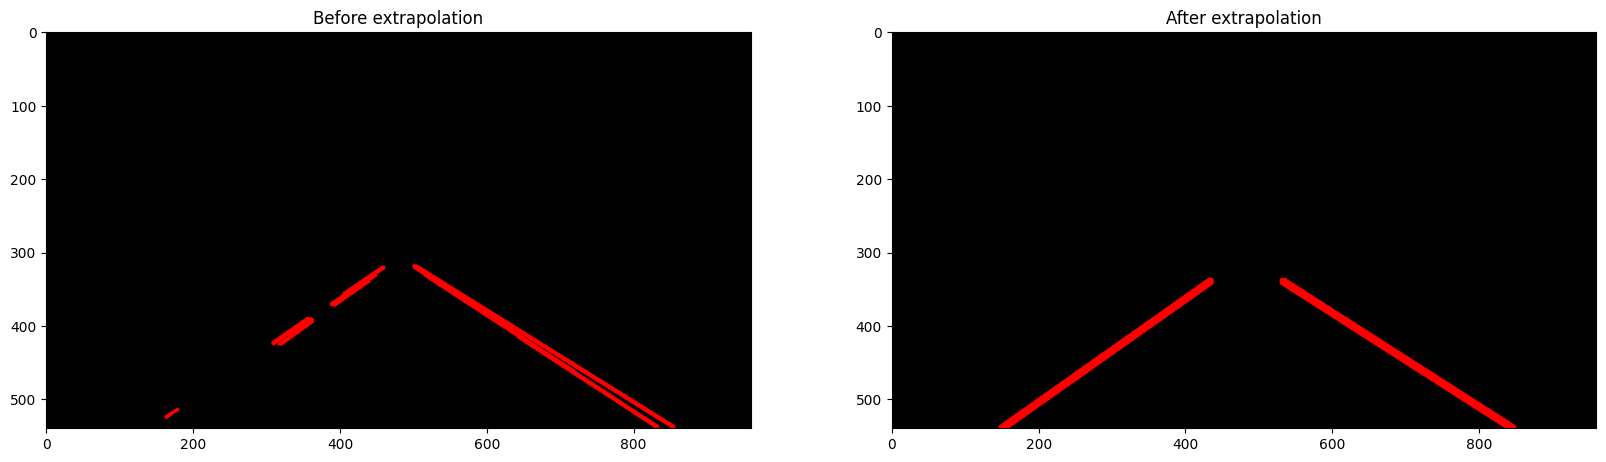

In [18]:
# Extract extrapolation lanes and draw lane lines
# Define bounds of the region of interest.
roi_upper_border = 340
roi_lower_border = 540

# Create a blank array to contain the (colorized) results.
lanes_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)

# Use above defined function to identify lists of left-sided and right-sided lines.
lines_left, lines_right = separate_left_right_lines(lines)

# Use above defined function to extrapolate the lists of lines into recognized lanes.
lane_left = extrapolate_lines(lines_left, roi_upper_border, roi_lower_border)
lane_right = extrapolate_lines(lines_right, roi_upper_border, roi_lower_border)
draw_lines(lanes_img, [[lane_left]], thickness=10)
draw_lines(lanes_img, [[lane_right]], thickness=10)

# Display results.
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(1, 2, 1); plt.imshow(hough); ax.set_title("Before extrapolation")
ax = fig.add_subplot(1, 2, 2); plt.imshow(lanes_img); ax.set_title("After extrapolation")
plt.show()

## 6. Blend Results Together

As a final step, we can combine the detected lanes with the original image of the road.

True

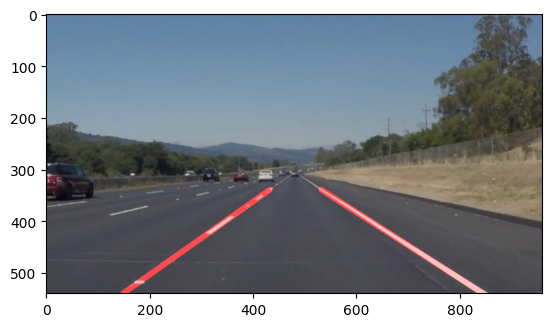

In [20]:
alpha = 0.8
beta = 1.0
gamma = 0.0
image_annotated = cv2.addWeighted(img, alpha, lanes_img, beta, gamma)

# Display the results, and save image to file.
plt.imshow(image_annotated)
img_annotated = cv2.cvtColor(image_annotated, cv2.COLOR_BGR2RGB)
cv2.imwrite("Lane1-image.jpg", image_annotated)